# SHIP: inference

This part of the tutorial explains in more details how to use SHIP to perform the system simulation after building a network.

## Run a network model

### Preliminary action: build a network

First and foremost, let's rapidly build a simple network, composed by a set of poisson neurons **poissonN**, a set of leaky-integrate neurons  **liN**, connected by a set of synapses modelled as a 2nd-order leaky synapse (**lS_2o**)

In [1]:
import sys
sys.path.append('C:\\') # to be edited by the user

from torch import rand
from SHIP import (network,  # <-- network object
                  poissonN, # <-- poisson neuron object
                  liN,      # <-- LI neuron object
                  lS_2o)    # <-- 2nd order leaky synapse object

net = network()
net.add(poissonN, 'P', N= 3, rate = 100)
net.add(liN, 'O', N = 2, tau_beta_ = lambda n: .05+rand(n))
net.add(lS_2o, 'PO',source = 'P',target = 'O', w__ = rand, tau_alpha1 = .01, tau_alpha2 = .004)

### Initialize a network

Now that we have our simple network, we can proceed with the initialization.

As anticipated in the previous tutorial, the initialization method `network.init` calls a set of internal routines that consolidate the **network**'s inner properties, and generate/store where needed the group models' variables and parameters. The initialization method is required before running a simulation.

The init method can also be used to set three of the required simulation parameters:
- the number of parallel batches `batch_size` (default = 1),
- the number of time-steps `nts` (default = 1),
- and the size of the time-step, `dt` (in seconds; again, default = 1).

We can do all of it as follows:

In [2]:
bs = 1 # batch size
nts = 100 # number of time-steps
dt = 0.001 # size of the time-step

net.init(batch_size = 1, dt = dt, nts = nts)

print("in principle, the parameters can be also accessed directly as the network's or group's properties:")
print("batch_size = ",net.batch_size)
print("nts = ",net.nts)
print("dt = ",net.dt)

in principle, the parameters can be also accessed directly as the network's or group's properties:
batch_size =  1
nts =  100
dt =  0.001


For this reason, such names must be avoided during the coding of a model (otherwise the group model might not work properly).

Nonetheless - at this stage we have a **network** object ready to support the simulation of its temporal evolution for a duration of ```nts``` timesteps of size ```dt```.

### Define an output

It would be possible to already run a simulation; but, by default, the **network** object does NOT store any information along the temporal simulation, unless explicitly required by the user.

There are two ways to do so. One is the definition of a **network** output. Doing so, **network** ackowledges that its output corresponds to the one of a group, as expressed by the user. To do so, we define the argument *is_output* as `is_output = True` during the group declaration stage, or using the `network.set_params` method. 

See example below, where we define the network output as the **liN** group output:

In [3]:
net.set_params('O', is_output = True)
net.init()

Also remember to initialize the network after any modification of its structure or parameters.

(Note: provision of *batch_size*, *dt*, *nts* arguments is not required again, as those are stored permanently during any of the previous initialization calls).

### Run the network simulation

At this stage, the network can simulate a temporal evolution AND store the data in the `network.output` property.

To run the simulation, we call the `network.run` method:

In [4]:
net.run()

Here we show the shape of the results gathered after the simulation:

In [5]:
net.output.shape

torch.Size([1, 100, 2])

and we plot what the simulation determined against the temporal axis, which can be recalled by using the ```network.timeline``` method:

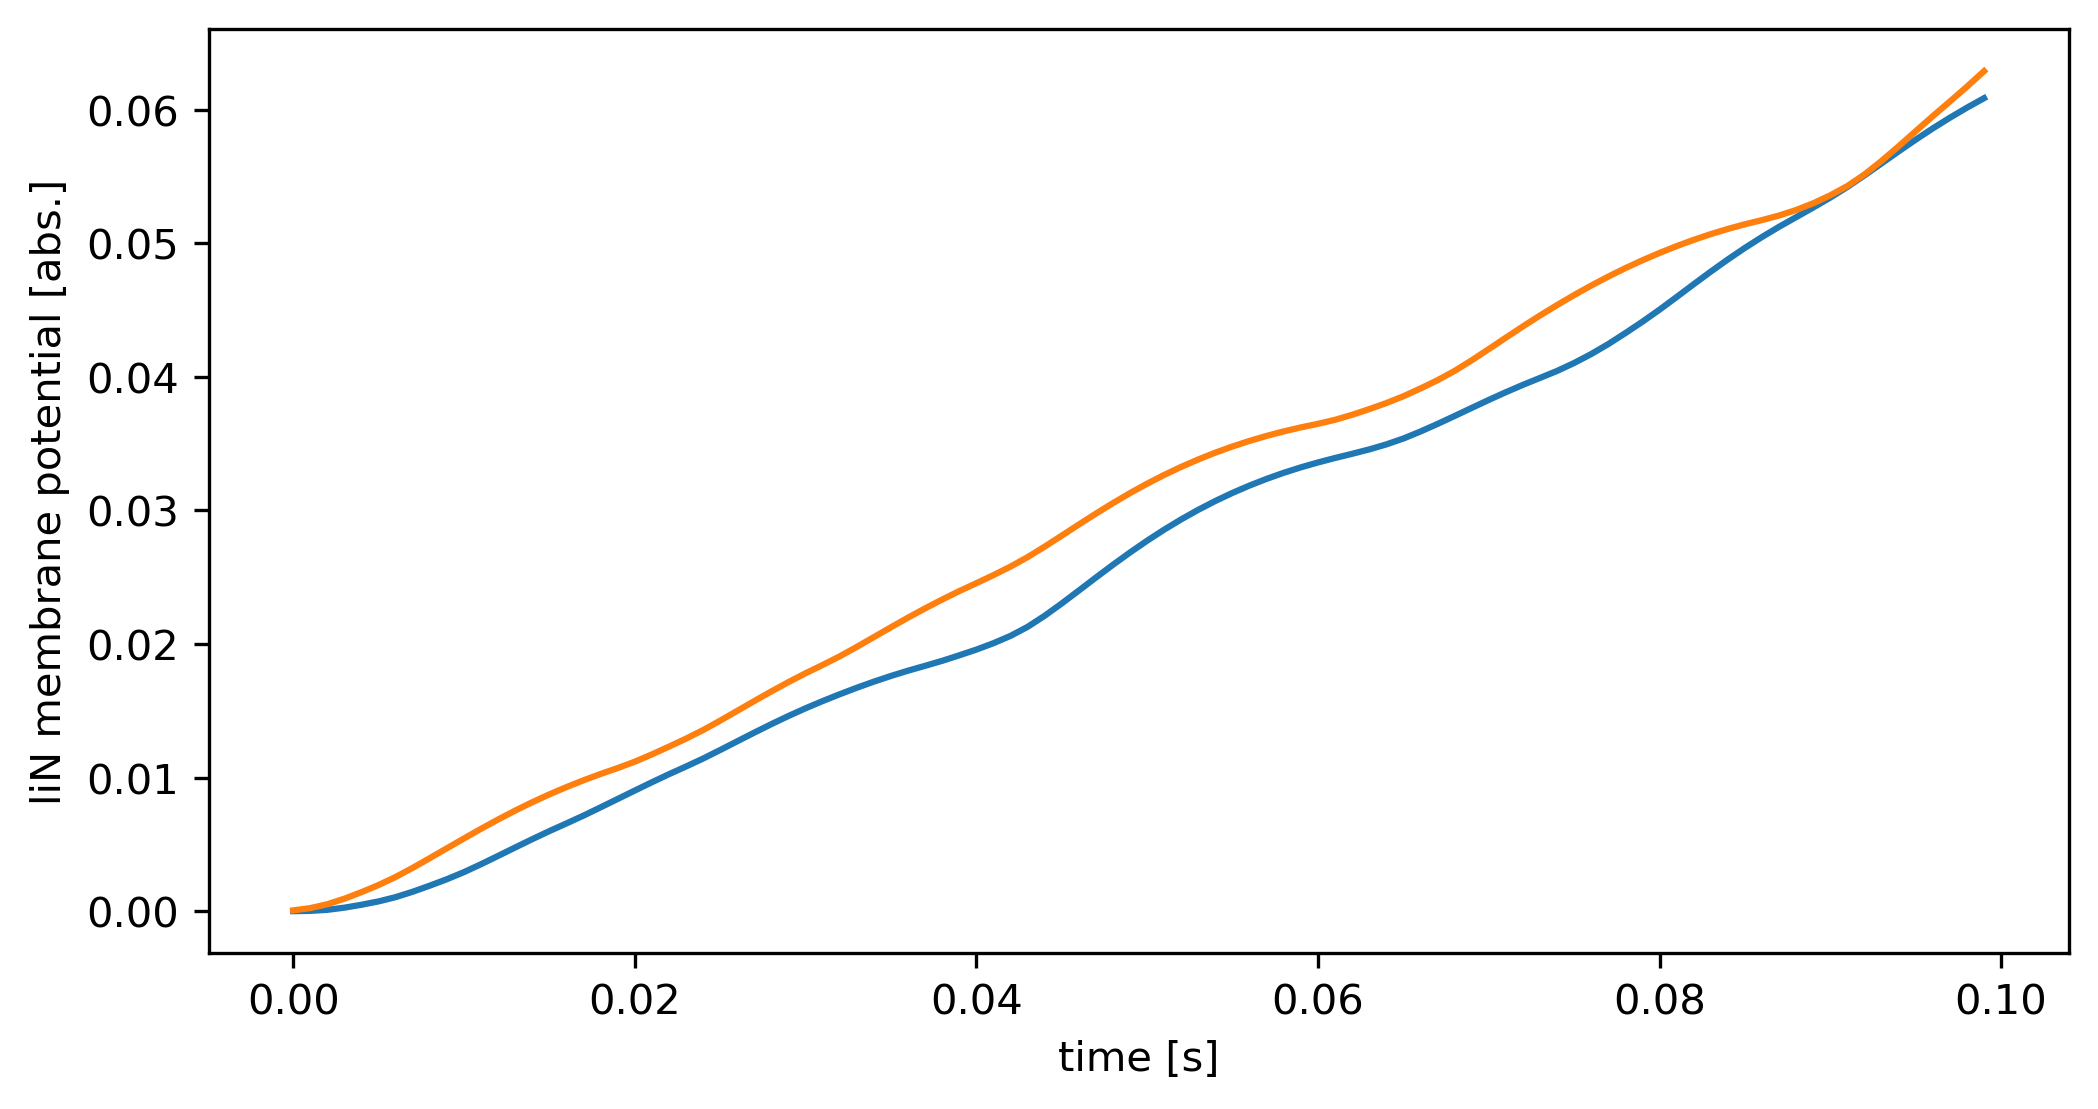

In [6]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,1, dpi = 300, figsize = (8,4))
ax.plot(net.timeline(), net.output[0,:,:])
ax.set_xlabel('time [s]')
ax.set_ylabel('liN membrane potential [abs.]');

### Set monitors and retrieve monitored data

We repeat the simulated experiment, here though we track i) the poisson randomly-generated spikes, and ii)how the synapse current evolves thorugh time. 

To store the time evolution of any of the network parameters or variables, we need to use the `network.set_monitor` method. This method set a wrapper function that catches the group's output at each timestep, and store it permanently. Its (positional) arguments are the name of the group and the name of the desired variable/parameter, all in string format (lists of strings can also be used). 

To gather the results, we use the argument-less method `network.get_monitored_data`.

We repeat the experiment above and plot the simulated results, this time tracking the poisson spikes, which are the output of the **poissonN** model; and the current state of the synapse model **lS_1o**

We underline that monitors require the user to state the name of any variable or parameter of the model of a network's group; however, the model output can also be stored in the same way, regardless of the presence of an ad-hoc variable having such a role.

See example below:

In [7]:
net.set_monitor(**{'P':['output'],'PO':['I1','I2']})
# alternatively one can set one variable at a time, without using lists
# net.set_monitor('P','output')
# net.set_monitor('PO','I1')
# net.set_monitor('PO','I2')

net.run()
data = net.get_monitored_results() # get all monitors
pSpikes = data.P.output # get_monitored_results() is a dictionary, accessible by dot notation, 
                        # where data is reachable as group_tag.variable_name
I = data.PO.I1+data.PO.I2

As visible above, the data returned by the `get_monitored_results()` method is a dictionary, modified to allow data access by using the dot notation in place of the conventional square-braket notation. 

Each element in the dictionary has the same key (name) as the group tag (e.g. data.P contains the results of the group 'P').

Each value is again a dictionary, containing the simulation results structured in the same way (here, the key corresponds to the monitored variable/parameter).

Thus, the returned value of data is essentially a tree where each branch correspond to the monitored groups, and each leaf corresponds to the monitored variables of the monitored groups. We note that the assumption underpinning this methodology is that each monitored variable is numeric.

We plot our results below:

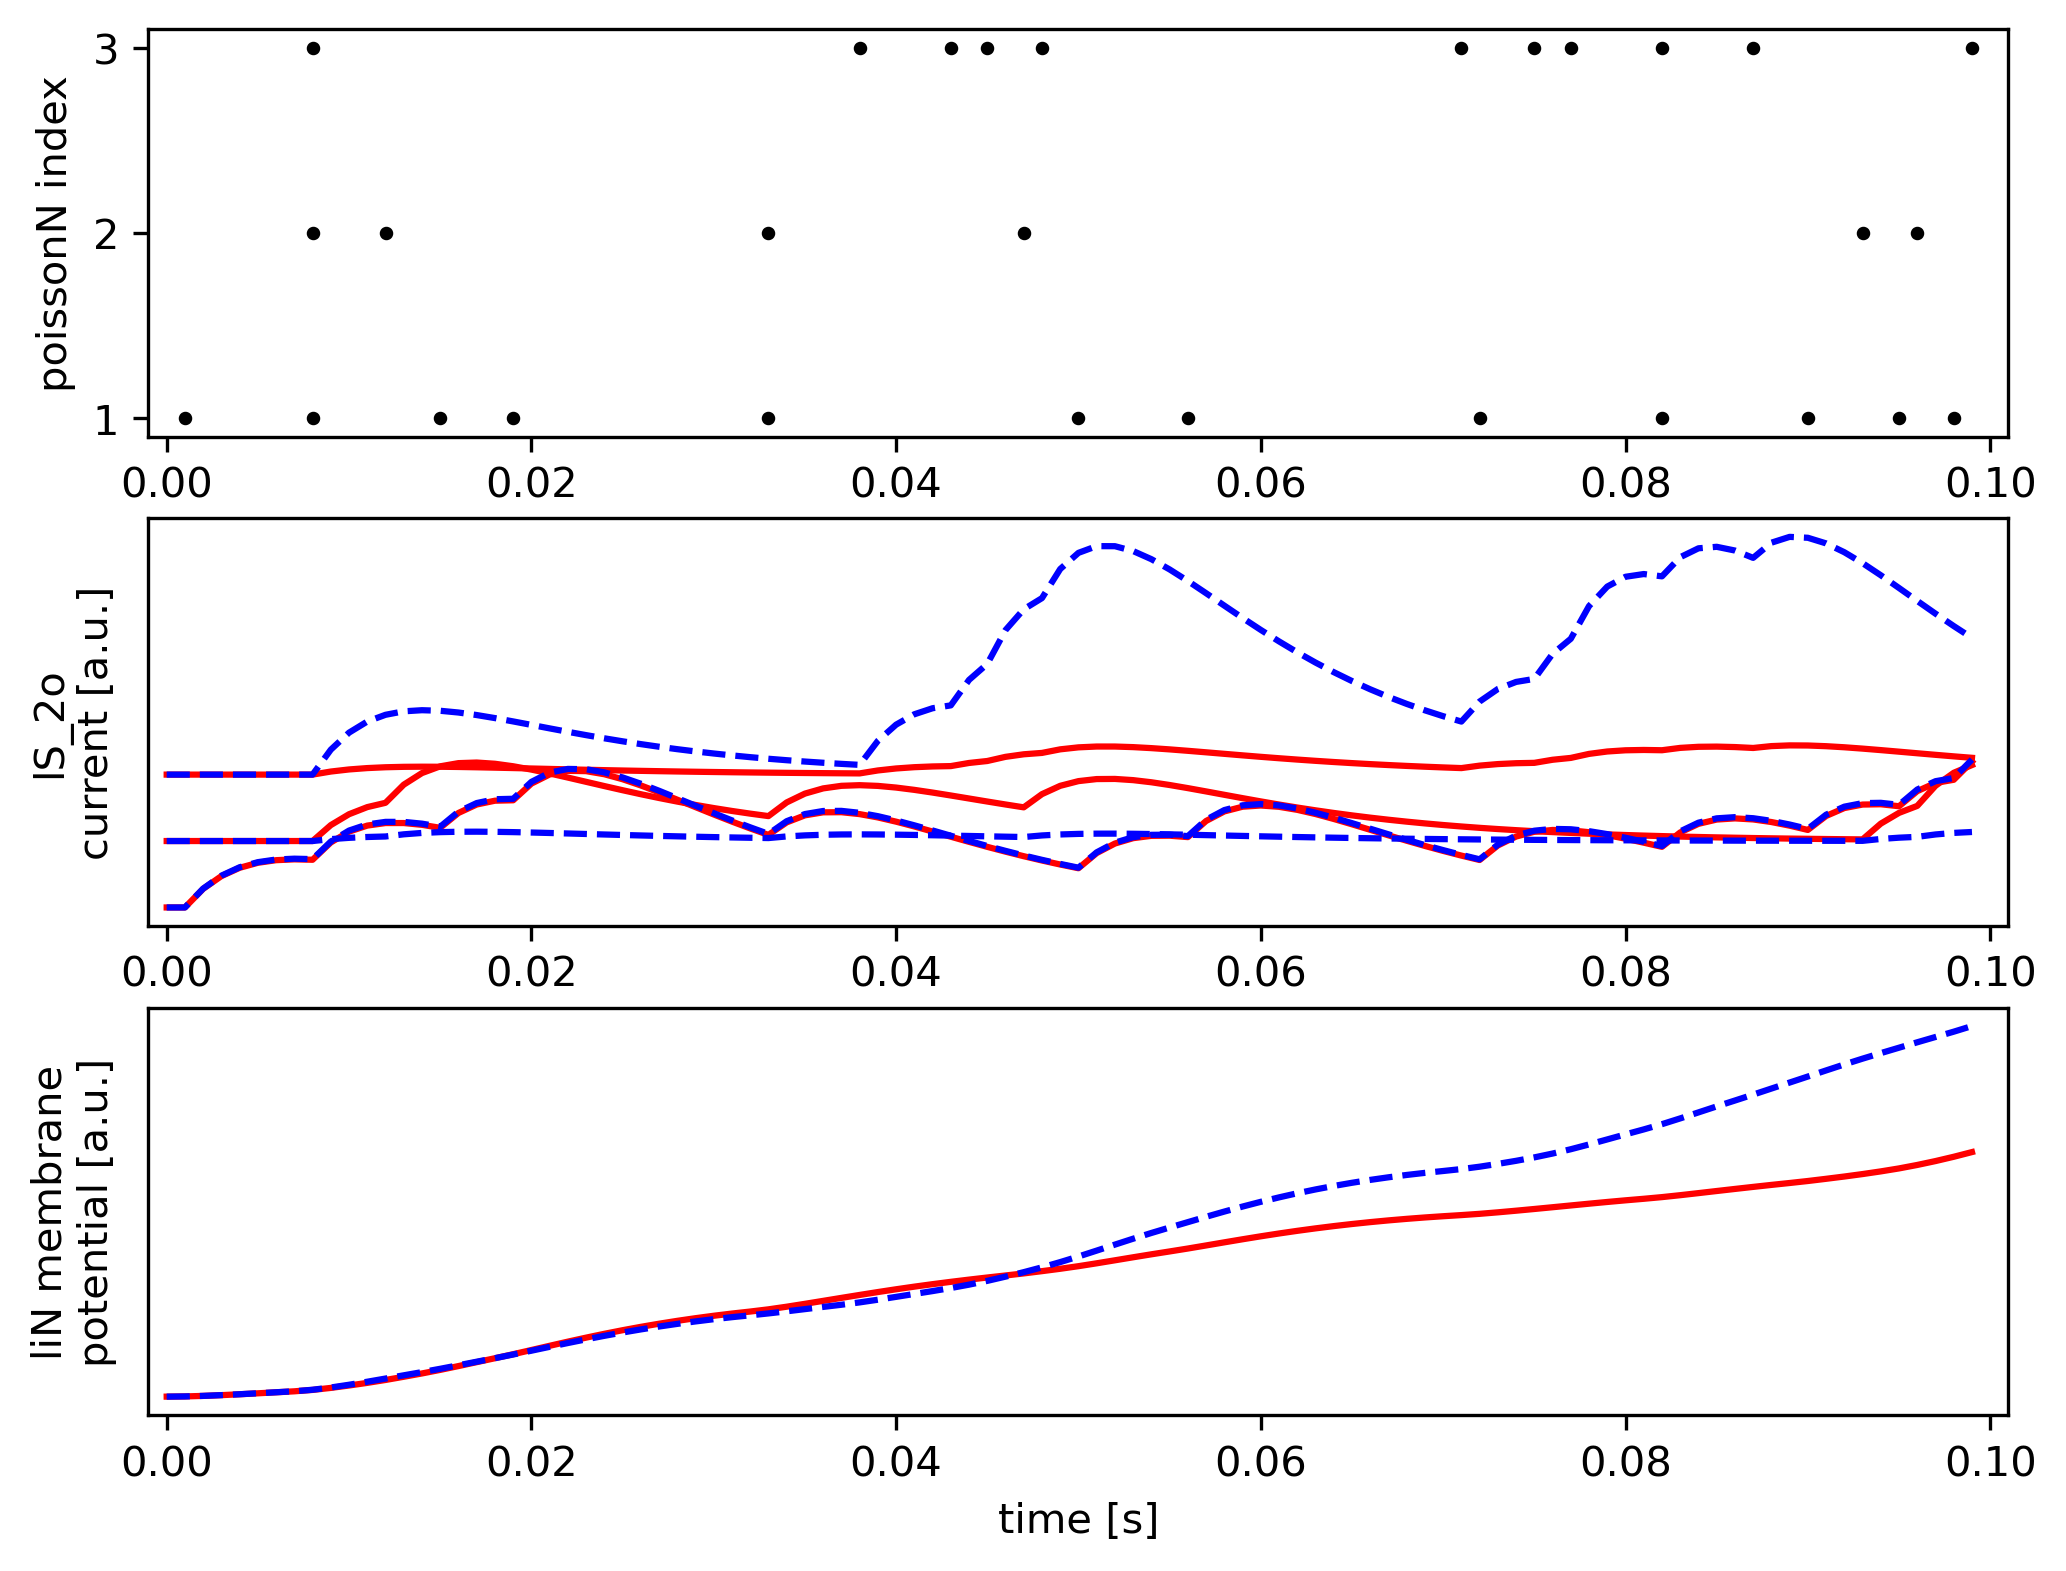

In [8]:
f,ax = plt.subplots(3,1, dpi = 300, figsize = (8,6))

# poissonN spikes
nU = net.groups.P.N # retrieval of 'P' number of components
xx = net.timeline().unsqueeze(1).expand(nts,nU)[pSpikes[0,:,:]]
from torch import arange
yy = arange(1,nU+1).unsqueeze(0).expand(nts,nU)[pSpikes[0,:,:]]
ax[0].scatter(xx,yy,s=5,color = [0,0,0])
ax[0].set_ylabel('poissonN index')
ax[0].set_yticks(arange(1,nU+1))
ax[0].set_xlim([-dt,(nts+1)*dt])

# lS_2o synaptic current
offset = 1/nU*arange(1,nU+1).unsqueeze(0).expand(nts,nU)
ax[1].plot(net.timeline(), I[0,:,:,0]+offset, color='r')
ax[1].plot(net.timeline(), I[0,:,:,1]+offset, linestyle = 'dashed',color='b')
ax[1].set_ylabel('lS_2o\ncurrent [a.u.]')
ax[1].set_yticks([])
ax[1].set_xlim([-dt,(nts+1)*dt])

#liN membrane potential 
ax[2].plot(net.timeline(), net.output[0,:,0], color = 'r')
ax[2].plot(net.timeline(), net.output[0,:,1], linestyle = 'dashed', color = 'b')
ax[2].set_xlabel('time [s]')
ax[2].set_ylabel('liN membrane\npotential [a.u.]')
ax[2].set_yticks([])
ax[2].set_xlim([-dt,(nts+1)*dt]);

### Use of wrapper functions to add functionalities

This section integrates the one showing how to build a network, but it is placed here as it is easier to show the effect of the wrapper function with a simulation.

This platform allows to use wrapper functions to include functionalities that are otherwise not defined within a group model.
We show a couple of important examples that use this strategy: definition of a refractory functionality on a lif neuron, and definition of a delay time on a synaptic model.

Refractoriness can be included by way of the `refractory` function. This applies to any neuronal model that uses the *integrate* variable to assess whether to integrate the incoming input. An alternative function, `refractory_variabletimestep`, perform the same function, with a different algorithmic implementation. Future version will likely merge the two function into one. The latter has been developed specifically to add this functionality also in case of a variable-timestepping approach.

Delay functionality is added by way opf the `delayed` function (no variabletimestep version present as of yet).

We take the network above, we add a few more groups (**lifN** simple lif neurons, and **lS_1o** 1st order leaky synapses). We add to those the refractory and delay functionality.

In [9]:
from SHIP import (lifN,
                  lS_1o,
                  refractory_variabletimestep as refr,
                  delayed)

net.add(refr(lifN),'N',N=2,tau_beta_ = 0.03, thr = 0.02, refr_time = 0.02)
net.add(lS_1o,'PN',source='P',target='N')
net.add(delayed(lS_1o),'NO',source='N',target='O',delay_time = 0.02)
net.init()

We monitor the **lifN** group membrane potential *u* and output, as well as the output of the 'NO' **lS_1o** group, to observe the refractoriness and delay in action. We run the simulation and plot the output:

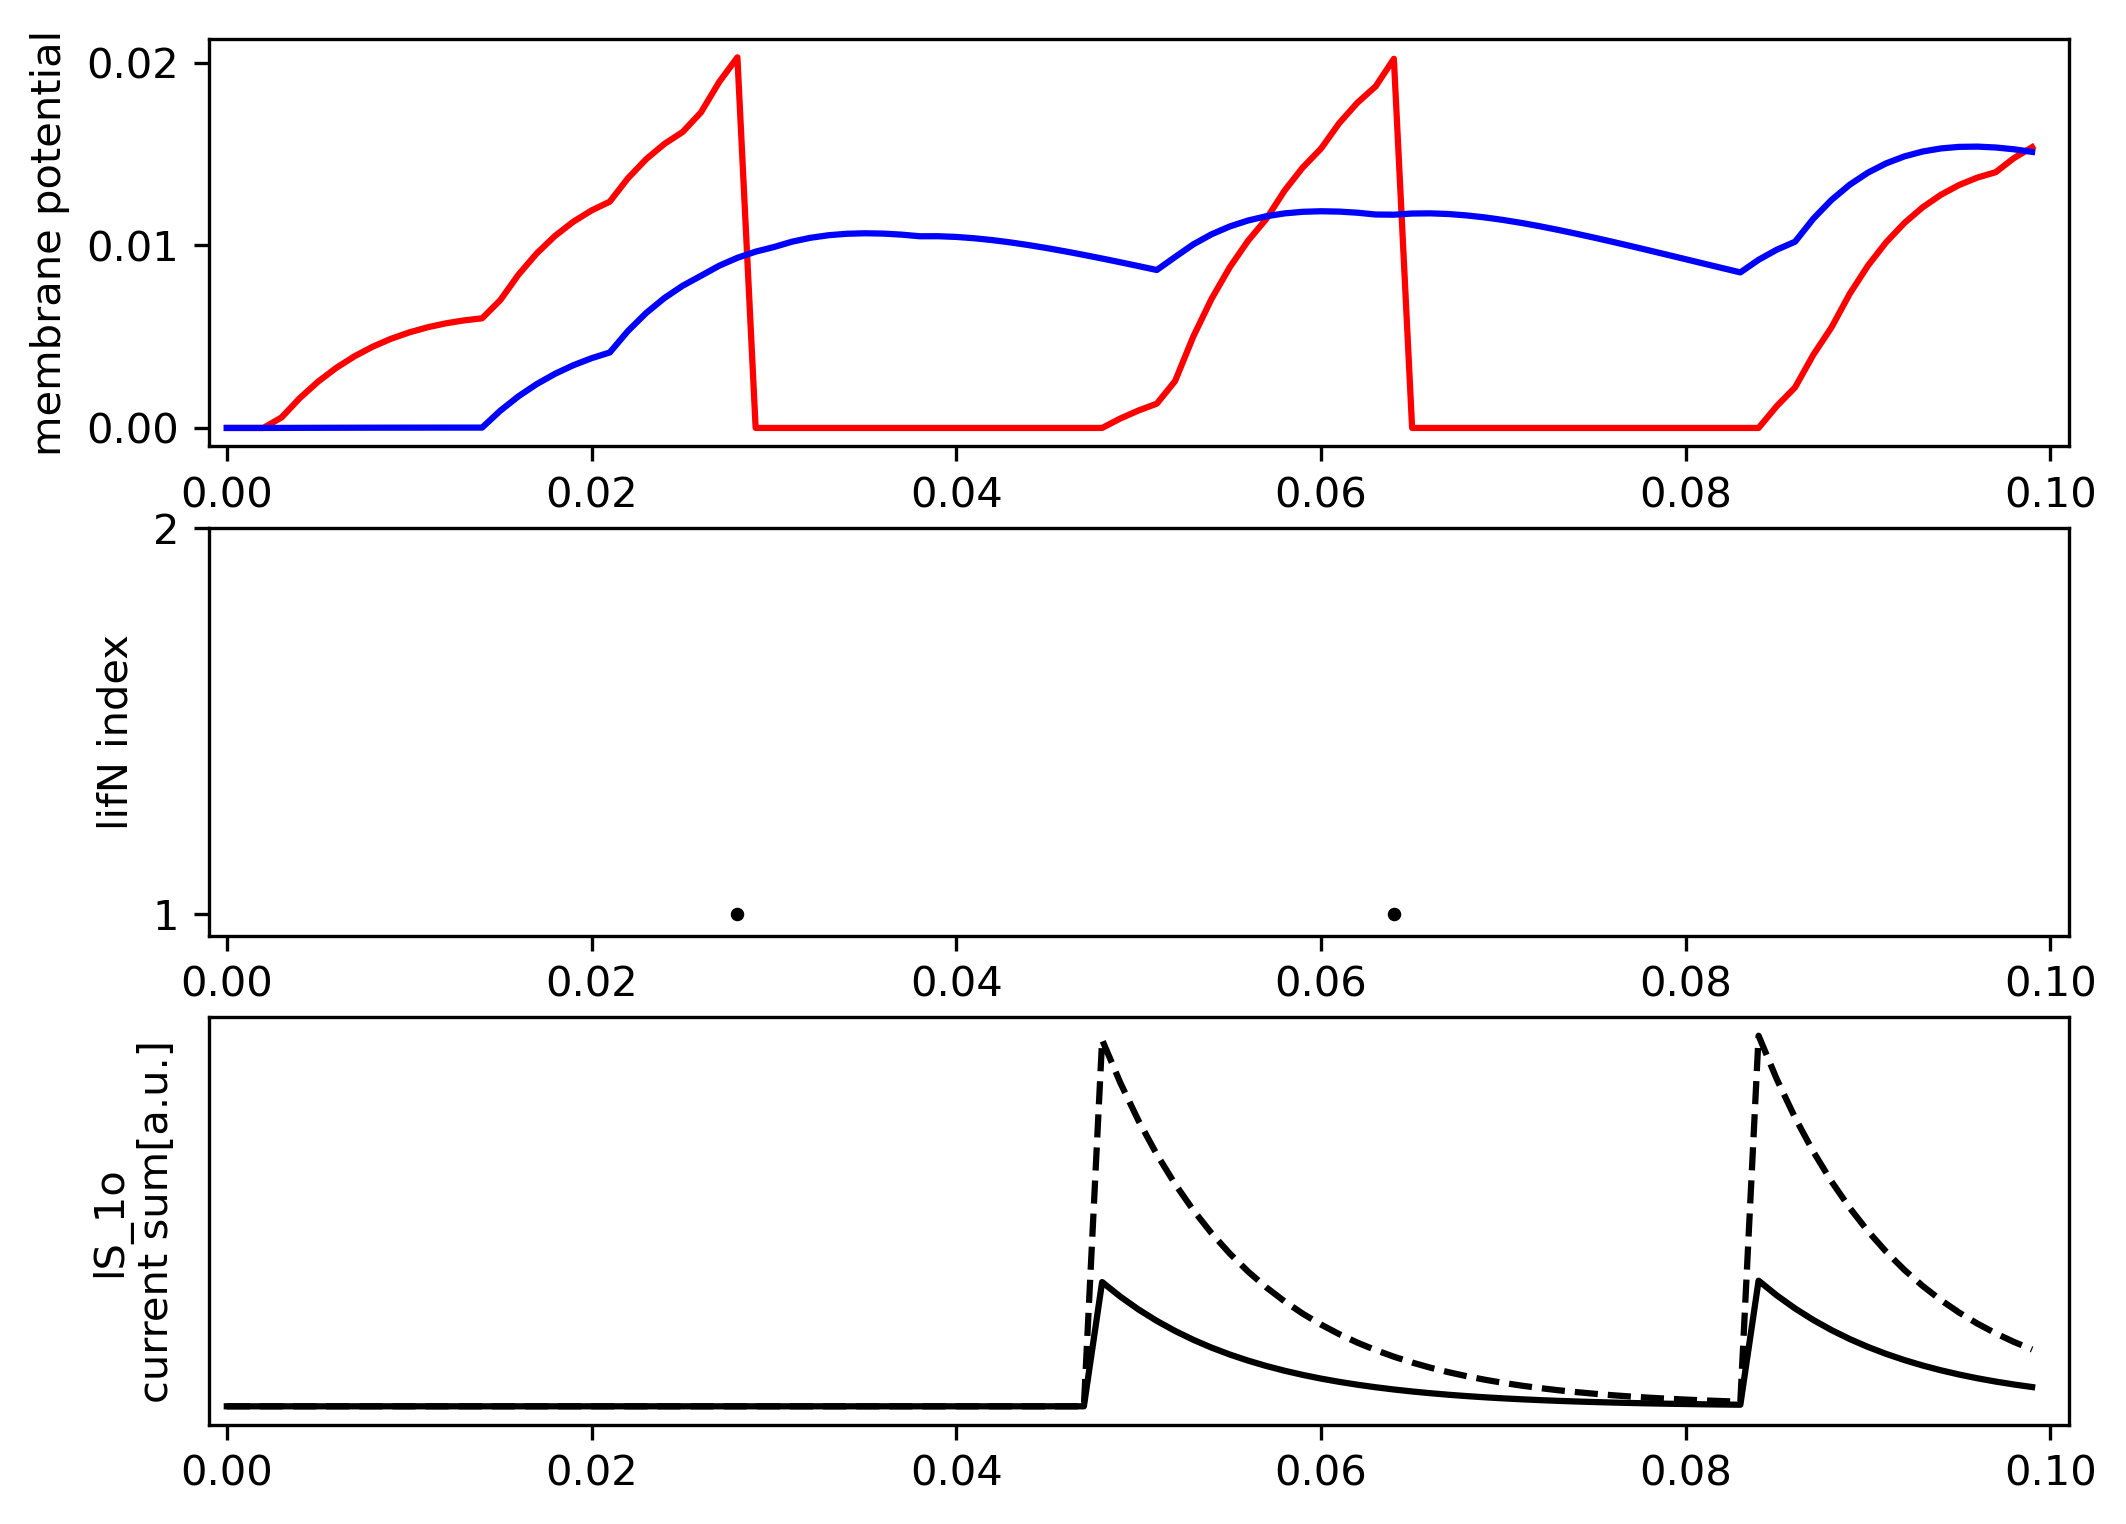

In [10]:
net.set_monitor(**{'N':['u','output'],'NO':['output']})
net.run()

data = net.get_monitored_results()

f,ax = plt.subplots(3,1, dpi = 300, figsize = (8,6))

# lifN membrane potential

ax[0].plot(net.timeline(), data.N.u[0,:,0],color = 'r')
ax[0].plot(net.timeline(), data.N.u[0,:,1],color = 'b')
ax[0].set_ylabel('membrane potential')
ax[0].set_xlim([-dt,(nts+1)*dt])

# lifN spikes
lSpikes = data.N.output
nU = net.groups.N.N # retrieval of 'N' number of components
xx = net.timeline().unsqueeze(1).expand(nts,nU)[lSpikes[0,:,:]]
yy = arange(1,nU+1).unsqueeze(0).expand(nts,nU)[lSpikes[0,:,:]]
ax[1].scatter(xx,yy,s=5,color = [0,0,0])
ax[1].set_ylabel('lifN index')
ax[1].set_yticks(arange(1,nU+1))
ax[1].set_xlim([-dt,(nts+1)*dt])

# lS_2o synaptic current
I = data.NO.output
ax[2].plot(net.timeline(), I[0,:,0], color='k')
ax[2].plot(net.timeline(), I[0,:,1], linestyle = 'dashed',color='k')
ax[2].set_ylabel('lS_1o\ncurrent sum[a.u.]')
ax[2].set_yticks([])
ax[2].set_xlim([-dt,(nts+1)*dt]);

Hopefully it is evident that the refractory period of 20 ms, and the delay time of 20 ms, impact the dynamic behavior of the two models here shown.

### Multiple time-step sizes

SHIP uses a fixed - time-stepping approach, which can indeed be useful for some applications but can rapidly find downfalls if the number of timesteps becomes too high.

A way around this issue is to use the `network.run_multisteps` method. This method accepts a set of (dt-nts) tuples, that the user can use so to vary the time-step size along the simulation.

See an example below:

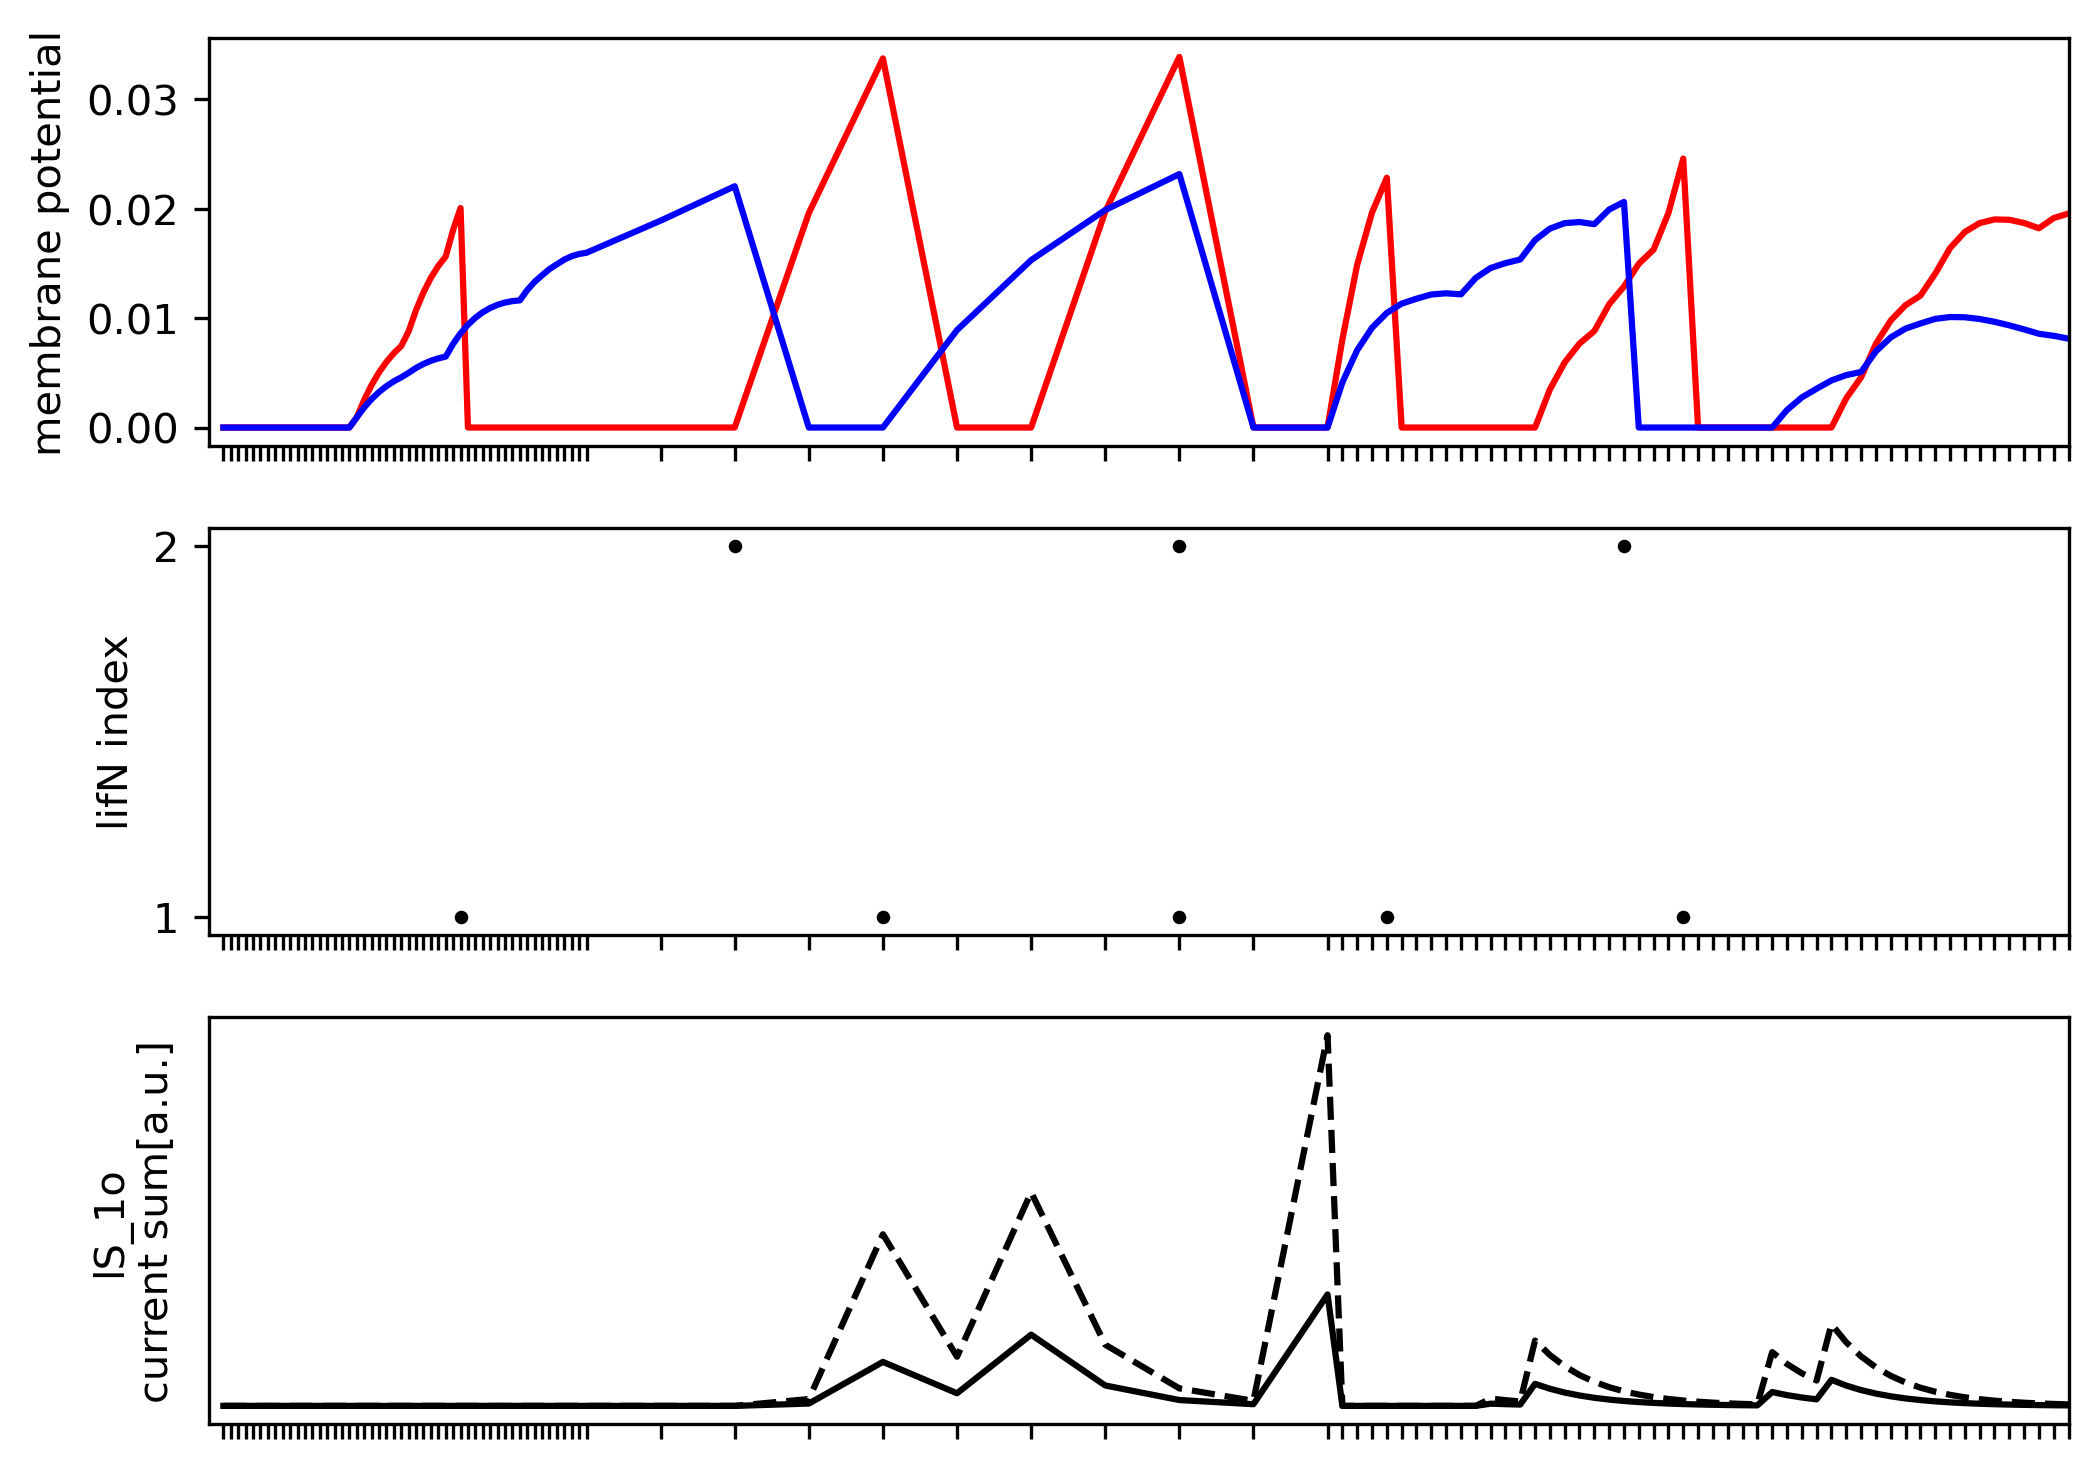

In [11]:
### simulation
list_of_simulated_params = ([.001,50],[0.01,10],[0.002,50])
net.run_multisteps(params = list_of_simulated_params)

### retrieving data
timeline = net.dt_sequence.cumsum_(0)# net.timeline() <-- currently it does not work - minor bug to be fixed soon!
data = net.get_monitored_results()


### plotting here
f,ax = plt.subplots(3,1, dpi = 300, figsize = (8,6))

# lifN membrane potential
ax[0].plot(timeline, data.N.u[0,:,0],color = 'r')
ax[0].plot(timeline, data.N.u[0,:,1],color = 'b')
ax[0].set_ylabel('membrane potential')
ax[0].set_xlim([-dt,(nts+1)*dt])
ax[0].set_xticks(timeline,labels = []);

# lifN spikes
lSpikes = data.N.output
nU = net.groups.N.N # retrieval of 'N' number of components
xx = timeline.unsqueeze(1).expand(timeline.shape[0],nU)[lSpikes[0,:,:]]
yy = arange(1,nU+1).unsqueeze(0).expand(timeline.shape[0],nU)[lSpikes[0,:,:]]
ax[1].scatter(xx,yy,s=5,color = [0,0,0])
ax[1].set_ylabel('lifN index')
ax[1].set_yticks(arange(1,nU+1))
ax[1].set_xlim([-dt,(nts+1)*dt])
ax[1].set_xticks(timeline,labels = []);


# lS_2o synaptic current
I = data.NO.output
ax[2].plot(timeline, I[0,:,0], color='k')
ax[2].plot(timeline, I[0,:,1], linestyle = 'dashed',color='k')
ax[2].set_ylabel('lS_1o\ncurrent sum[a.u.]')
ax[2].set_yticks([])
ax[2].set_xlim([-dt,(nts+1)*dt]);
ax[2].set_xticks(timeline,labels = []);


We highlighted the ticks, that hopefully evidence how the emulator vary the time-step size across the simulation time. The method `network.run_multisteps` is in an embrional stage, yet possibly not further developed as we aim to introduce a proper variable-time-step approach. However, at this stage, it provides an additional method with which one can perform long simulations without suffering from an explosion of the number of time-steps. 

This method is not widely applicable, but it can be very useful if one approximatively knows when to change the temporal resolution, or to introduce some time-skip effect (say - skip the emulation from *t* = 3 s to *t* = 5 s).

### Provide external stimuli

Of course, the system by itself is not extremely useful unless it can read user-defined data.

To do so, we defined an ad-hoc group that takes the role of network input-port: the **inputN** group (which acts as a neurongroup). If a network is provided with this group, during the `network.run` method (and also `run_multisteps` method) it gathers the user-provided arguments, stores internally, and returns to the network a slice of the input at each given time-step.

It is consequential that the input must follow the rigid data convention we previously defined (*batch_size*,*nts*,*nU*). During the simulation, the **inputN** model will send to its target synapses the time-step-dependent slices of the input, of size (*batch_size*,*nU*).

Let's rebuild a network using the **inputN** neuron as a listening port:

In [12]:
from SHIP import inputN
input_channels = 3

net = network()
net.add(inputN, 'I', N = input_channels)
net.add(refr(lifN),'N',N=2,tau_beta_ = 0.03, thr = 1, refr_time = 0.02)
net.add(lS_1o,'IN',source='I',target='N', w__ = rand, w_scale = 50)

Let's now define a random input, just for the sake of example:

In [13]:
batch_size, dt, nts = 5, 0.001, 100
random_spikes = rand(batch_size,nts,input_channels)<0.1 # now we have some spikes to start with

We can now run a simulation of our network stimulated by our defined input, and see the effect on the results

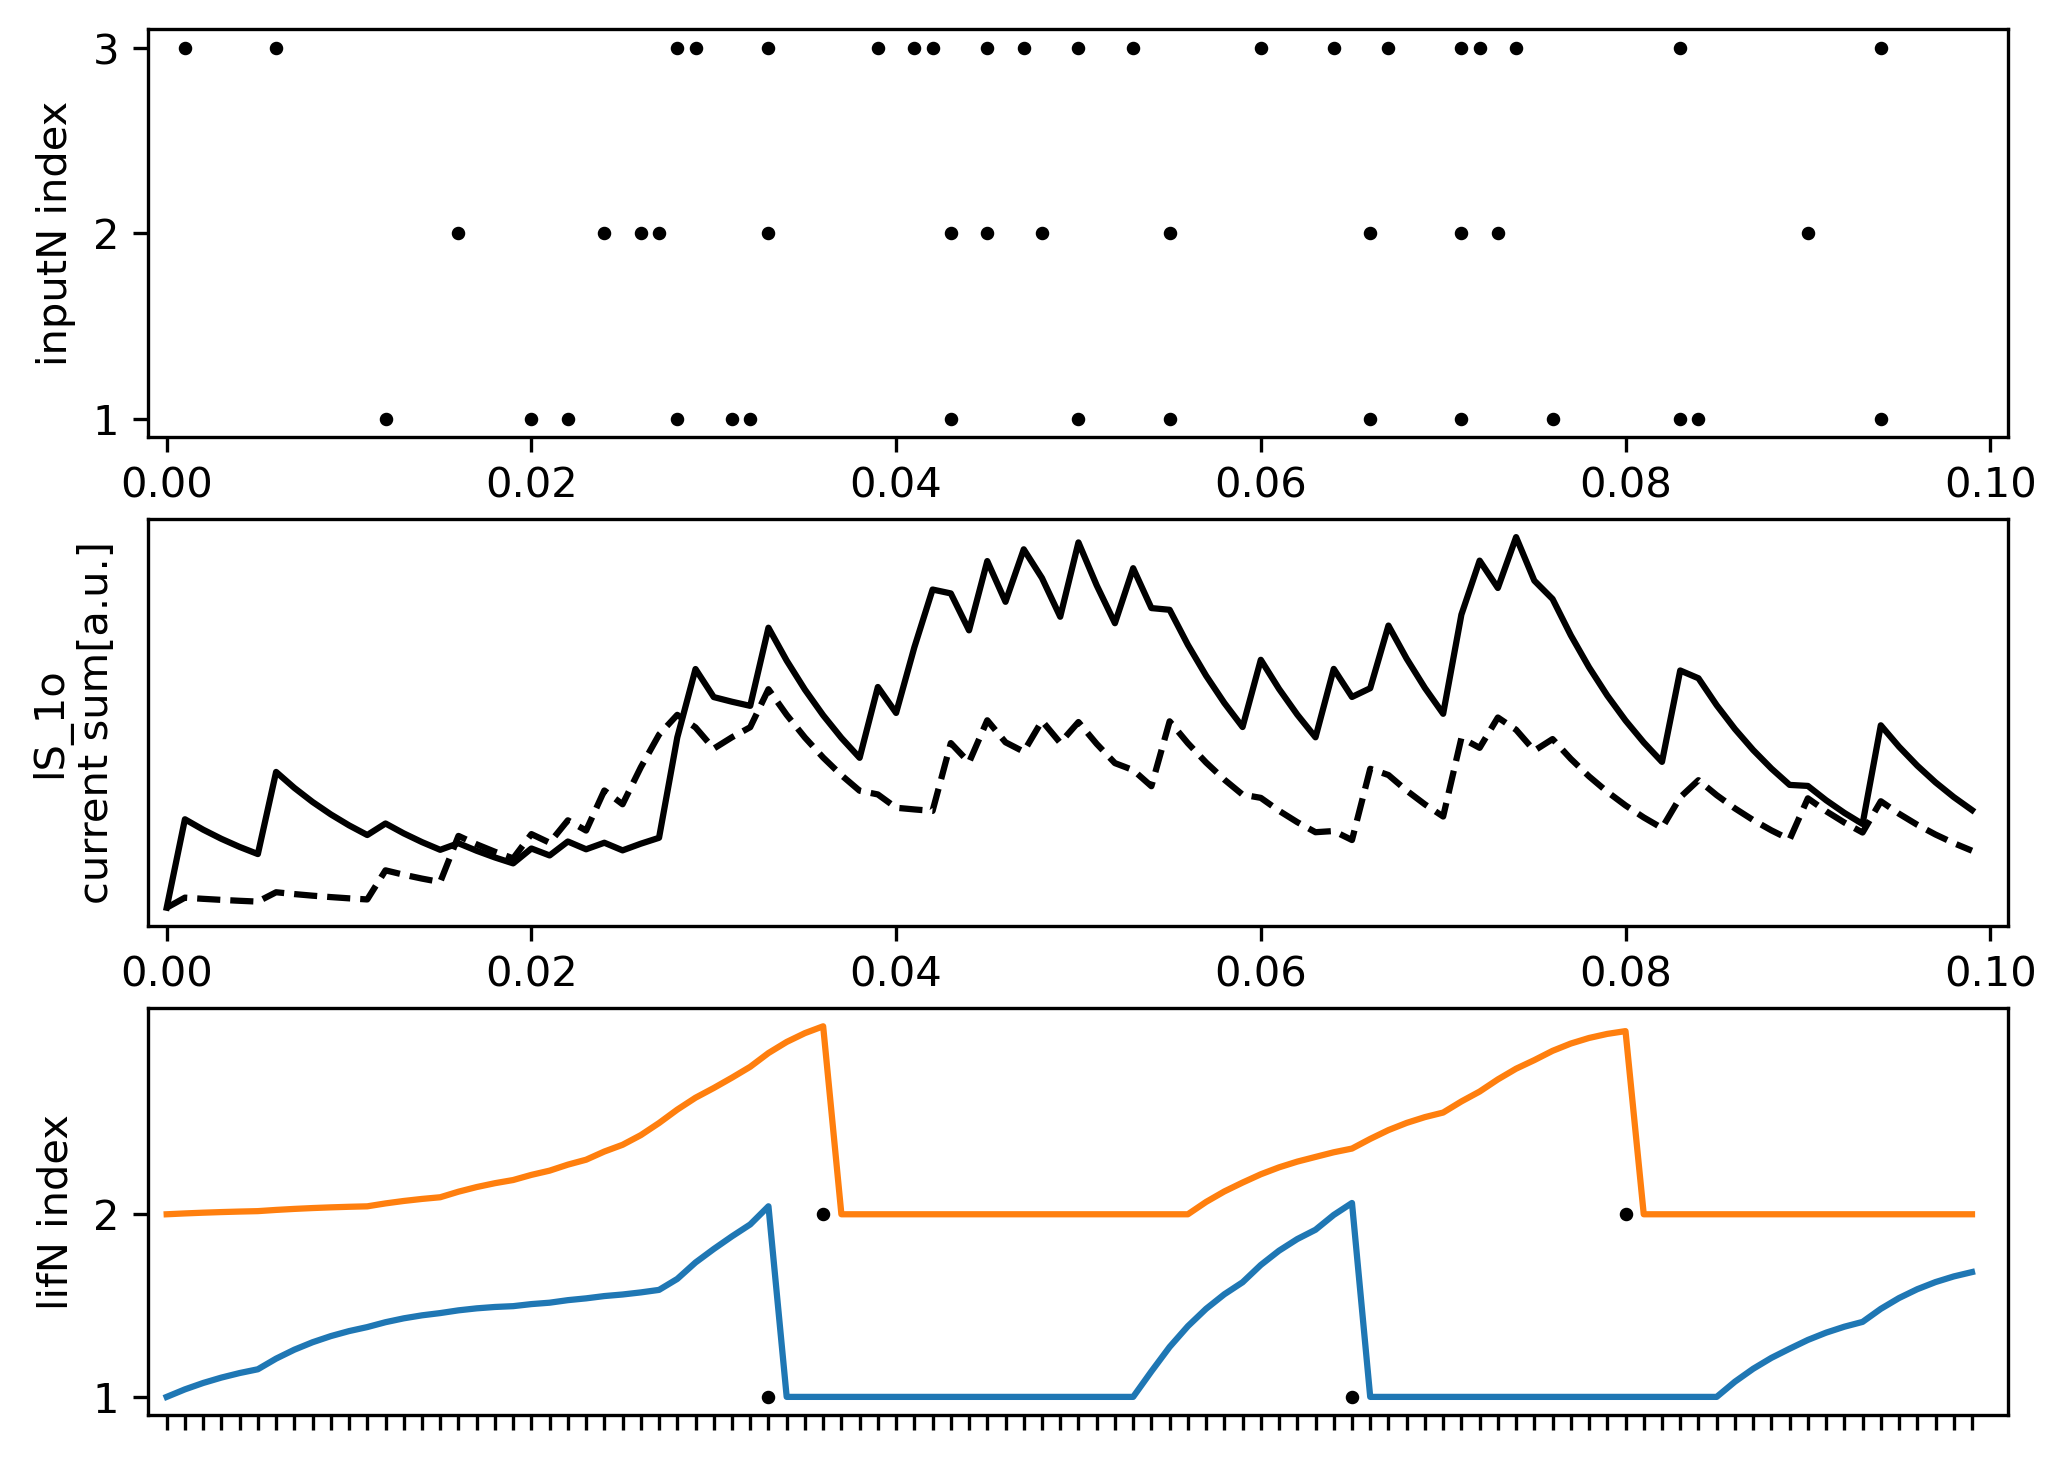

In [14]:
from torch import arange

### simulation here
net.init(batch_size = batch_size, nts = nts, dt = dt)
net.set_monitor(**{'I':['output'],
                   'N':['u','output'],
                   'IN':['output']})

### run method providing an external input
net.run(random_spikes)


### retrieving data
timeline = net.timeline()
data = net.get_monitored_results()



### plotting here
f,ax = plt.subplots(3,1, dpi = 300, figsize = (8,6))

# input spikes
Spikes = data.I.output
nU = net.groups.I.N # retrieval of 'N' number of components
xx = timeline.unsqueeze(1).expand(timeline.shape[0],nU)[Spikes[0,:,:]]
yy = arange(1,nU+1).unsqueeze(0).expand(timeline.shape[0],nU)[Spikes[0,:,:]]
ax[0].scatter(xx,yy,s=5,color = [0,0,0])
ax[0].set_ylabel('inputN index')
ax[0].set_yticks(arange(1,input_channels+1))
ax[0].set_xlim([-dt,(nts+1)*dt])

# lS_1o synaptic current
I = data.IN.output
ax[1].plot(timeline, I[0,:,0], color='k')
ax[1].plot(timeline, I[0,:,1], linestyle = 'dashed',color='k')
ax[1].set_ylabel('lS_1o\ncurrent sum[a.u.]')
ax[1].set_yticks([])
ax[1].set_xlim([-dt,(nts+1)*dt]);

# lifN spikes
Spikes = data.N.output
U = data.N.u
nU = net.groups.N.N # retrieval of 'N' number of components
xx = timeline.unsqueeze(1).expand(timeline.shape[0],nU)[Spikes[0,:,:]]
yy = arange(1,nU+1).unsqueeze(0).expand(timeline.shape[0],nU)[Spikes[0,:,:]]
ax[2].plot(timeline.unsqueeze(1).expand(nts,nU), U[0,:,:]+arange(1,nU+1).unsqueeze(0).expand(nts,nU))
ax[2].scatter(xx,yy,s=5,color = [0,0,0])
ax[2].set_ylabel('lifN index')
ax[2].set_yticks(arange(1,nU+1))
ax[2].set_xlim([-dt,(nts+1)*dt])
ax[2].set_xticks(timeline,labels = []);





The last code snippet summarizes how to use an emulated network to process some externally-provided data.

We underline that **inputN** accepts only tensor data, that must have proper shape (*batch_size*, *nts*, **inputN**.*N*).
However, a different model, **list_inputN**, has been specifically designed to read list data, which can become useful in case of unevenly-sized inputs (although, the simulation of a batch is still bound to run for the duration of a single timeline; it is not possible to run simulations in parallel with different number of timesteps).

### More info on the variables and parameters initialization

The call of `network.init` stores the groups' parameters values where needed be (by calling the generator functions as shown in Tutorial_1). This is essential to retrieve the values of the parameters, as well as to consolidate the network structure and perform other automated operations.

The groups' variables instead are set in the model in a different stage, precisely at the beginning of the `network.run` method (which internally calls the `network.shallow_init` method, the one actually taking care of this operation).

The decision to split the variables and parameters storage has been made so to enable the user to differentiate what should remain static during the simulation (parameters), and what is expected to change during the simulation (variables). But the decision to carry out the variables initialization in a different stage is due to the fact that the user might NOT want to reset the variables. In particular, the user might want to 
- carry out the simulation for a certain amount of time, 
- stop it to do some post-processing, analysis, or any other arbitrary operation, 
- and only then continue starting from the network *at the stage it was left at*.
This is not possible by calling the run method, which internally resets the variables using the default (or user-provided) variables. 

### Continuing a simulation from where it was left at
Therefore, the `network.run` calls for a few methods: 
- the already-cited `network.shallow_init`, that sets the groups' variables;
- the `network.run_` method, which is the one actually performing the simulation;
- in case no output is indicated, `network.run` alternatively calls `network.run_no_out`
- eventually, the `network.post`, which at the moment is merely a placeholder that may be used for future developments.

Nevertheless, the user might want to initially launch the simulation using `network.run`,but then follow up using `network.run_` or `network.run_no_out`, which skips the `shallow_init`, and reprises the simulation from the stage it was left at. 

Let's see this in action. We repeat the simulation carried out before, but for a limited number of time-steps. Then we reprise the simulation using the `network.run_no_out` method.

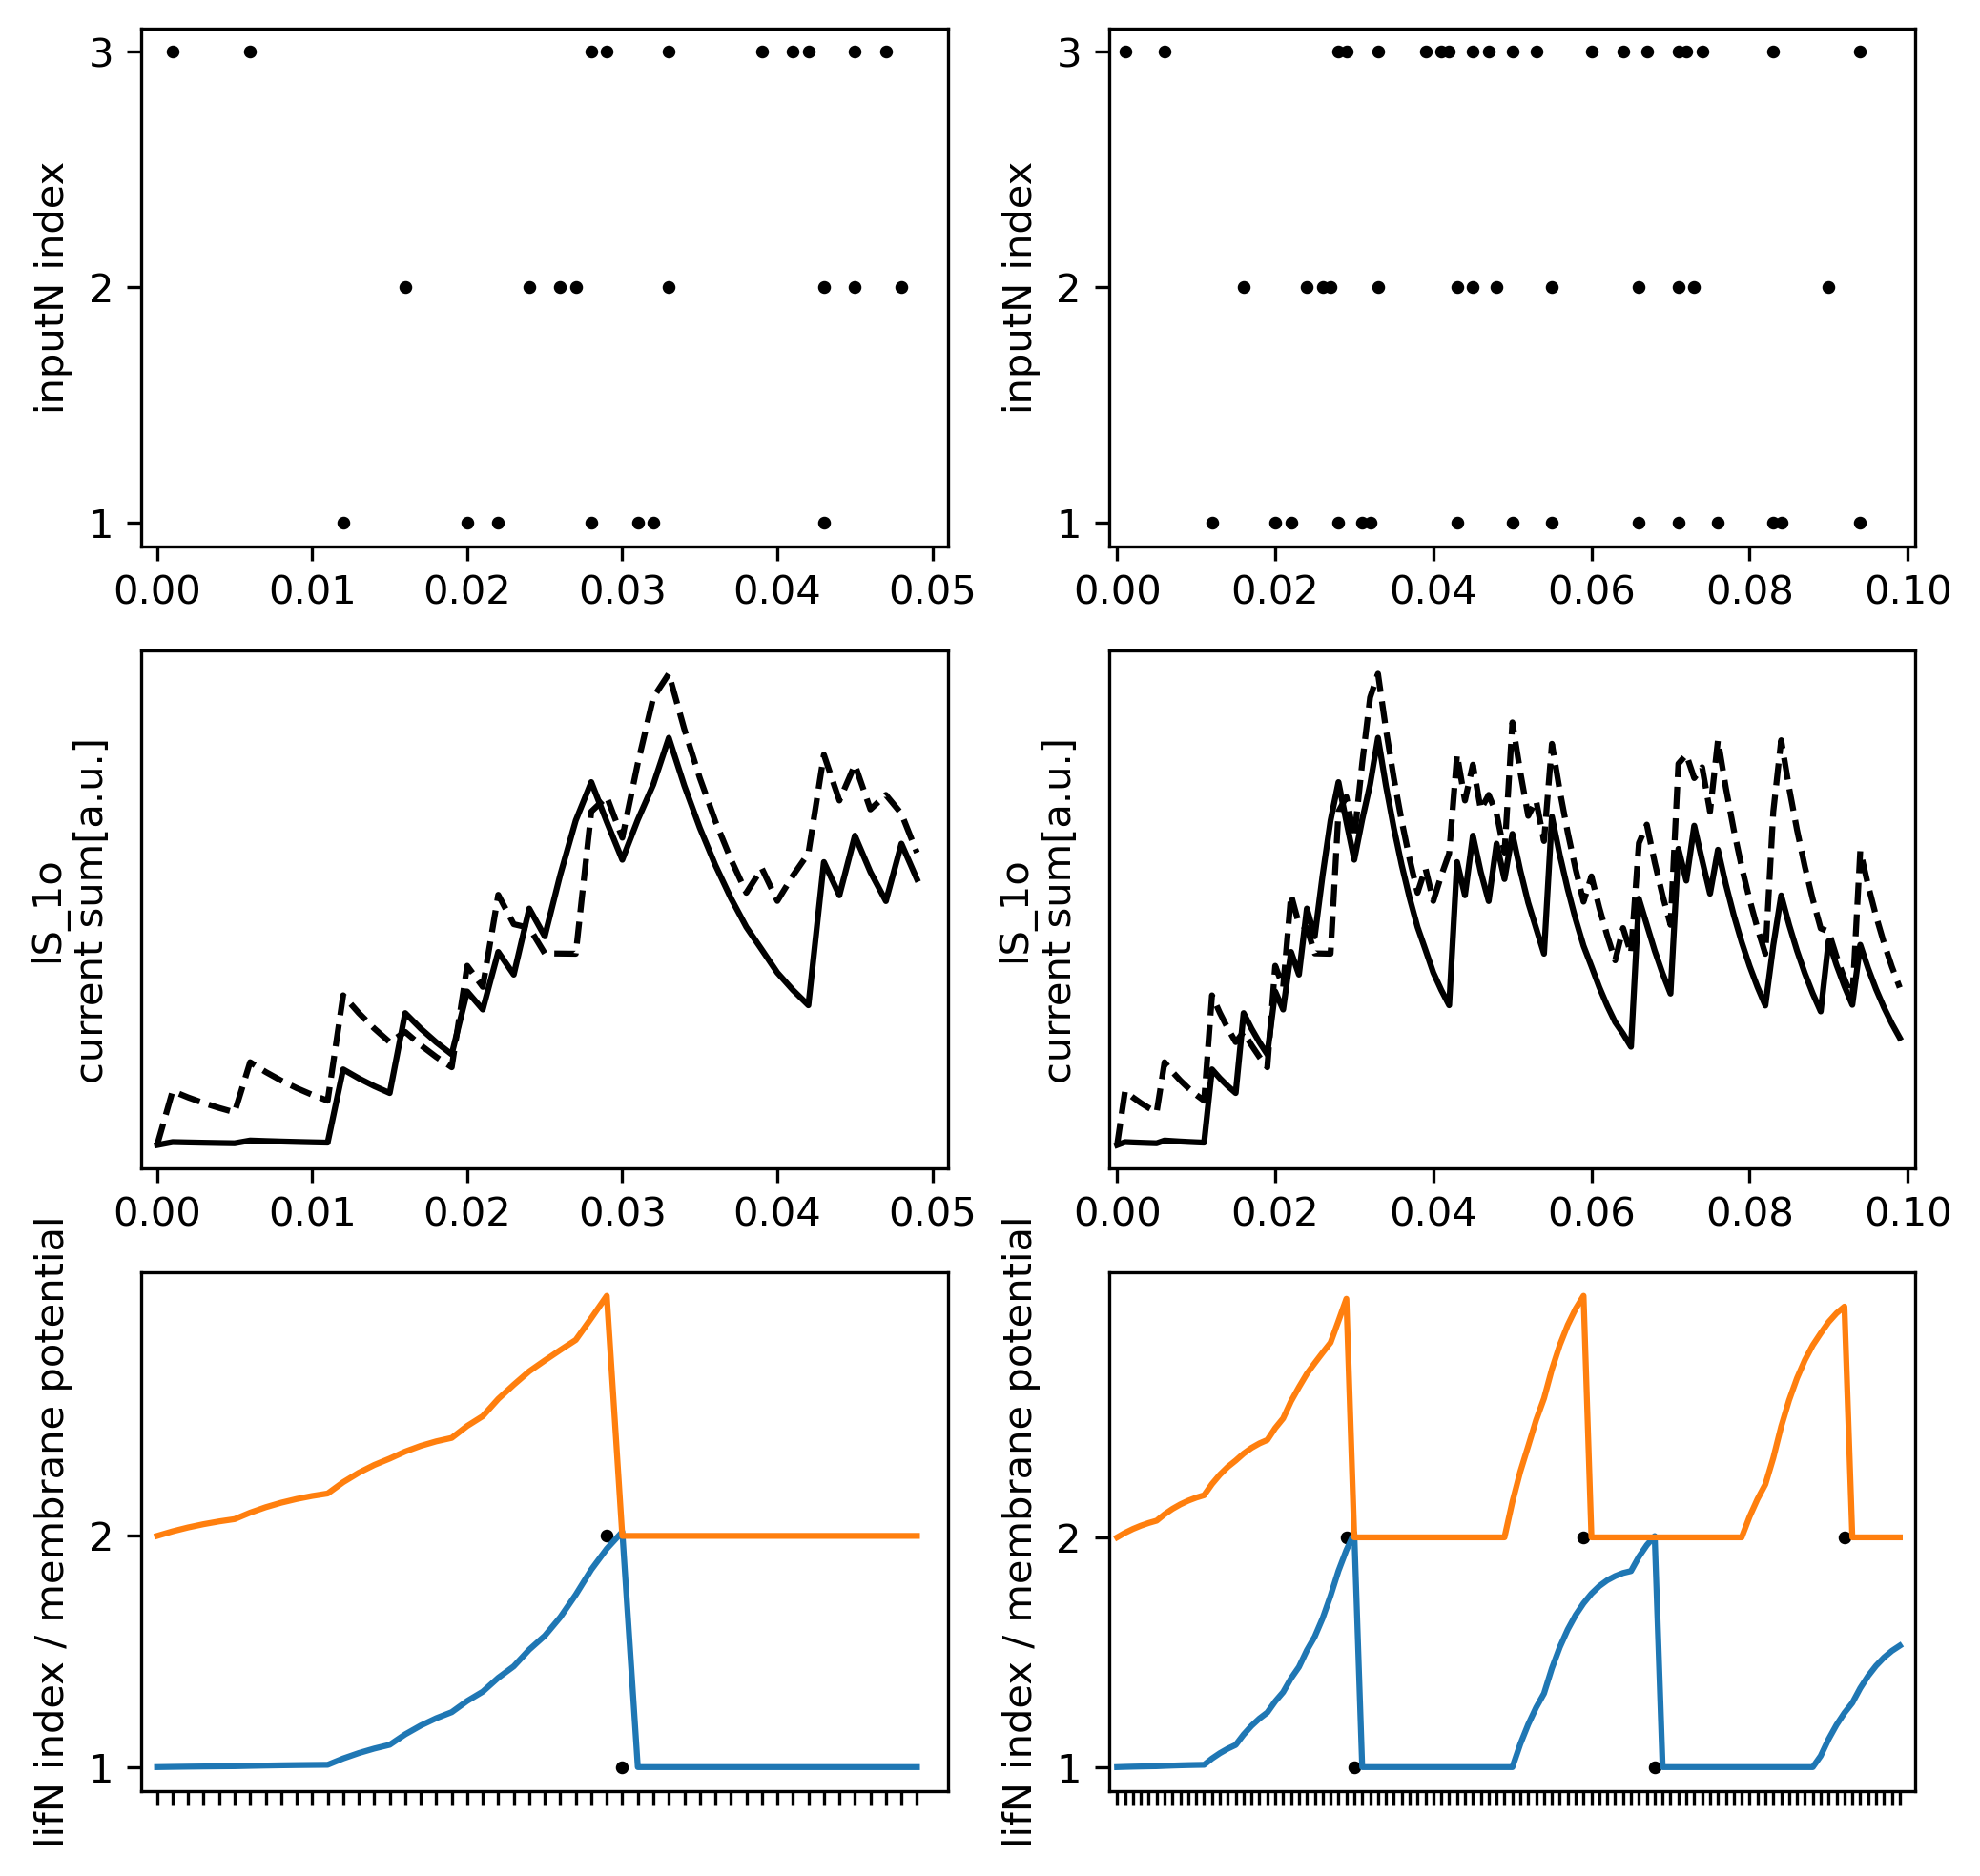

In [15]:
from torch import cat

############################ first half
nts = 50
net.init(nts = nts)

net.run(random_spikes)

### retrieving data
timeline0 = net.timeline()
l0 = timeline0.shape[0]
data = net.get_monitored_results()
## input
Spikes = data.I.output
nU = net.groups.I.N
xI0 = timeline0.unsqueeze(1).expand(l0,nU) [Spikes[0,:,:]]
yI0 = arange(1,nU+1).unsqueeze(0).expand(l0,nU)[Spikes[0,:,:]]
## synapse
I0 = data.IN.output
## lif neuron
Spikes = data.N.output
U0 = data.N.u
nU = net.groups.N.N
xN0 = timeline0.unsqueeze(1).expand(l0,nU)[Spikes[0,:,:]]
yN0 = arange(1,nU+1).unsqueeze(0).expand(l0,nU)[Spikes[0,:,:]]

############################ second half
net.run_no_out()

### retrieving data
timeline1 = cat((timeline0,timeline0[-1]+dt+net.timeline()),0) # here we need to concatenate two timelines, as run_ and run_no_out reset the timeline
l1 = timeline1.shape[0]
data = net.get_monitored_results()
## input
Spikes = data.I.output
nU = net.groups.I.N
xI1 = timeline1.unsqueeze(1).expand(l1,nU) [Spikes[0,:,:]]
yI1 = arange(1,nU+1).unsqueeze(0).expand(l1,nU)[Spikes[0,:,:]]
## synapse
I1 = data.IN.output
## lif neuron
Spikes = data.N.output
U1 = data.N.u
nU = net.groups.N.N
xN1 = timeline1.unsqueeze(1).expand(l1,nU)[Spikes[0,:,:]]
yN1 = arange(1,nU+1).unsqueeze(0).expand(l1,nU)[Spikes[0,:,:]]

############################# plot results
f,ax = plt.subplots(3,2, dpi = 300, figsize = (8,8))

########## first half
ii = 0
# input
ax[0][ii].scatter(xI0,yI0,s=5,color = [0,0,0])
ax[0][ii].set_ylabel('inputN index')
ax[0][ii].set_yticks(arange(1,input_channels+1))
ax[0][ii].set_xlim([-dt,(l0+1)*dt])
# lS_1o synaptic current
ax[1][ii].plot(timeline0, I0[0,:,0], color='k')
ax[1][ii].plot(timeline0, I0[0,:,1], linestyle = 'dashed',color='k')
ax[1][ii].set_ylabel('lS_1o\ncurrent sum[a.u.]')
ax[1][ii].set_yticks([])
ax[1][ii].set_xlim([-dt,(l0+1)*dt]);
# lifN spikes
ax[2][ii].plot(timeline0.unsqueeze(1).expand(l0,2), U0[0,:,:]+arange(1,2+1).unsqueeze(0).expand(l0,2))
ax[2][ii].scatter(xN0,yN0,s=5,color = [0,0,0])
ax[2][ii].set_ylabel('lifN index / membrane potential')
ax[2][ii].set_yticks(arange(1,2+1))
ax[2][ii].set_xlim([-dt,(l0+1)*dt])
ax[2][ii].set_xticks(timeline0,labels = []);

########## second half
ii = 1
# input
ax[0][ii].scatter(xI1,yI1,s=5,color = [0,0,0])
ax[0][ii].set_ylabel('inputN index')
ax[0][ii].set_yticks(arange(1,input_channels+1))
ax[0][ii].set_xlim([-dt,(l1+1)*dt])
# lS_1o synaptic current
ax[1][ii].plot(timeline1, I1[0,:,0], color='k')
ax[1][ii].plot(timeline1, I1[0,:,1], linestyle = 'dashed',color='k')
ax[1][ii].set_ylabel('lS_1o\ncurrent sum[a.u.]')
ax[1][ii].set_yticks([])
ax[1][ii].set_xlim([-dt,(l1+1)*dt]);
# lifN spikes
ax[2][ii].plot(timeline1.unsqueeze(1).expand(l1,2), U1[0,:,:]+arange(1,2+1).unsqueeze(0).expand(l1,2))
ax[2][ii].scatter(xN1,yN1,s=5,color = [0,0,0])
ax[2][ii].set_ylabel('lifN index / membrane potential')
ax[2][ii].set_yticks(arange(1,2+1))
ax[2][ii].set_xlim([-dt,(l1+1)*dt])
ax[2][ii].set_xticks(timeline1,labels = []);

Mind that the initialization takes place with `network.init`, but the input is stored internally as a parameter of the **inputN** group as it is passed with the first call to `network.run`. Therefore, the input does not vary nor it can be updated with the call to `network.run_no_out`, and the initially-provided input must last for all the planned emulation.

Possibly, future implementation will amend this limitation.